In [1]:
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../../utils/")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb
import requests
import re

import numpy as np
import pandas as pd
from functools import reduce
from collections import Counter

import networkx as nx

import signal

import warnings
warnings.filterwarnings("ignore")

from wiki_intro_scrapper import WikiIntroScrapper
from WikiMultiQuery import wiki_multi_query
from graph_helpers import create_dispersion_df, sort_dict_values, format_categories, compare_categories

%aimport wiki_intro_scrapper
%aimport WikiMultiQuery
%aimport graph_helpers

In [17]:
class GraphCreator:

    def __init__(self, entry):
        self.graph = nx.DiGraph()

        self.entry = entry

        wis = WikiIntroScrapper(f"https://en.wikipedia.org/wiki/{entry}")
        wis.parse_intro_links()

        self.intro_nodes = wis.intro_link_titles

        self.visited = {entry}
        self.next_links = []
        
        self.categories = {}

        self.query_articles([entry])

        # setup timeout function

        def handle_alarm(signum, frame):
            raise RuntimeError

        signal.signal(signal.SIGALRM, handle_alarm)

    def add_edges(self, articles):
        for article in articles:
            
            self.categories[article['title']] = format_categories([category.split("Category:")[1] for category in article['categories'] if not bool(re.findall(r"(articles)|(uses)|(commons)|(category\:use)", category, re.I))])
            
            self.graph.add_edges_from(
                [(article['title'], link) for link in article['links']])
            self.graph.add_edges_from(
                [(linkhere, article['title']) for linkhere in article['linkshere']])

    def update_edge_weights(self):
        for edge in self.graph.out_edges:
            weight = compare_categories(edge[0], edge[1], self.categories)
            self.graph.add_edge(edge[0], edge[1], weight=weight)
            
        for edge in self.graph.in_edges:
            weight = compare_categories(edge[0], edge[1], self.categories)
            self.graph.add_edge(edge[0], edge[1], weight=weight)
    
    def get_edge_weights(self):
        edge_weights = []
        for edge in self.graph.edges:
            edge_weights.append((edge[0], edge[1], self.graph.get_edge_data(edge[0], edge[1])['weight']))
        
#         for edge in self.graph.in_edges:
#             edge_weights.append((edge[0], edge[1], self.graph.get_edge_data(edge[0], edge[1])['weight']))
        
        return pd.DataFrame(edge_weights, columns=["source_node", "target_node", "edge_weight"]).sort_values("edge_weight", ascending=False).reset_index().drop("index", axis=1)
    
    def plot_graph(self):
        nx.draw(self.graph)
        plt.show()

    def get_degrees(self):
        return sort_dict_values(dict(self.graph.degree()), ["node", "degree"], "degree",)

    def get_edges(self):
        in_edges = sort_dict_values(dict(Counter([edge[1] for edge in self.graph.in_edges()])), 
                            ['node', 'in_edges'], "in_edges")
        out_edges = sort_dict_values(dict(Counter([edge[0] for edge in self.graph.out_edges()])), 
                            ["node", 'out_edges'], 'out_edges')

        return in_edges.merge(out_edges, on="node")
    
    def get_centrality(self):
        return sort_dict_values(nx.eigenvector_centrality(self.graph, weight="weight"), ["node", "centrality"], "centrality")

    def get_dispersion(self, comparison_node=None, max_nodes=25_000):
        if not comparison_node:
            comparison_node = self.entry
            
        if max_nodes is None or len(self.graph.nodes) <= max_nodes:
            print("FULL")
            return sort_dict_values(nx.dispersion(self.graph, u=comparison_node), ['node', 'dispersion'], 'dispersion')
        else:
            print("EGO")
            # if the network is too large, perform calculation on ego graph of entry node
            ego = self.create_ego()
            return sort_dict_values(nx.dispersion(ego, u=comparison_node), ['node', 'dispersion'], 'dispersion')

    def get_pageranks(self):
        page_ranks = sorted([(key, value) for key, value in nx.algorithms.link_analysis.pagerank(
            self.graph, weight='weight').items()], key=lambda x: x[1], reverse=True)
        return pd.DataFrame(page_ranks, columns=["node", "page_rank"])

    def get_reciprocity(self):
        return sort_dict_values(nx.algorithms.reciprocity(self.graph, self.graph.nodes), ['node', 'reciprocity'], 'reciprocity')

    def get_adjusted_reciprocity(self):
        r = self.get_reciprocity()
        d = self.get_degrees()

        r_d = r.merge(d, on="node", how="inner")
        r_d['adjusted_reciprocity'] = r_d.reciprocity * r_d.degree

        adjusted_reci = r_d.sort_values("adjusted_reciprocity", ascending=False)
        return adjusted_reci.reset_index().drop(["degree", "reciprocity", "index"], axis=1)
    
    def get_shortes_path(self, source=None, ascending=False):
        if not source:
            source = self.entry
            
        paths = nx.algorithms.single_source_shortest_path_length(self.graph, source)
        return sort_dict_values(paths, ["node", "shortest_path_length_from_source"], "shortest_path_length_from_source", ascending=ascending)
    
    def get_dominator_counts(self, source=None):
        if not source:
            source = self.entry
            
        dom_dict = nx.algorithms.dominance.immediate_dominators(self.graph, start=source)
        
        dom_counts = {}

        for key, value in dom_dict.items():
            if value in dom_counts:
                dom_counts[value] += 1
            else:
                dom_counts[value] = 1
        for node in self.graph.nodes:
            if not node in dom_counts:
                dom_counts[node] = 0
        
        return sort_dict_values(dom_counts, ['node', 'immediate_dominator_count'], 'immediate_dominator_count')
    
    def get_hits(self):
        hits = nx.algorithms.link_analysis.hits_alg.hits(self.graph, max_iter=1000)
        return (sort_dict_values(hits[1], ['node', 'hits_authority'], 'hits_authority')
                .merge(sort_dict_values(hits[0], ['node', 'hits_hub'], 'hits_hub'), on="node"))
    
    def get_features_df(self):
        dfs = []
        
        dfs.append(self.get_degrees())
        dfs.append(self.get_edges())
        dfs.append(self.get_centrality())
        dfs.append(self.get_dispersion())
        dfs.append(self.get_pageranks())
        dfs.append(self.get_adjusted_reciprocity())
        dfs.append(self.get_shortes_path())
        
        return reduce(lambda left, right: pd.merge(left, right, on="node", how="outer"), dfs)
        
    
    def create_ego(self, node=None):
        if not node:
            node = self.entry

        ego = nx.ego_graph(self.graph, node)
        ego.name = node
        return ego

    def expand_network(self, group_size=10, timeout=10):

        num_links = len(self.next_links)

        link_group = []

        for i in range(num_links):
            link = self.next_links.pop(0)
            if not link in self.visited:

                link_group.append(link)

                if len(link_group) == group_size or (i == num_links - 1 and len(link_group) > 0):
                    print("{:.2%}".format(i/num_links))
                    try:
                        signal.alarm(timeout)
                        self.visited.update(link_group)
                        self.query_articles(link_group)
                        signal.alarm(0)
                        link_group = []
                    except:
                        link_group = []
                        continue
        signal.alarm(0)

    def update_next_links(self, articles):
        for article in articles:
            for link in article['links']:
                self.next_links.append(link)

    def query_articles(self, titles, generate_graph=True):
        articles = wiki_multi_query(titles)

        self.update_next_links(articles)
        self.add_edges(articles)

## TESTS

In [26]:
gc = GraphCreator("Sonata form")

In [27]:
len(gc.next_links)

311

In [28]:
gc.expand_network(group_size=2, timeout=5)

0.32%
0.96%
1.61%
2.25%
2.89%
3.54%
4.18%
4.82%
5.47%
6.11%
6.75%
7.40%
8.04%
8.68%
9.32%
9.97%
10.61%
11.25%
11.90%
12.54%
13.18%
13.83%
14.47%
15.11%
15.76%
16.40%
17.04%
17.68%
18.33%
18.97%
19.61%
20.26%
20.90%
21.54%
22.19%
22.83%
23.47%
24.12%
24.76%
25.40%
26.05%
26.69%
27.33%
27.97%
28.62%
29.26%
29.90%
30.55%
31.19%
31.83%
32.48%
33.12%
33.76%
34.41%
35.05%
35.69%
36.33%
36.98%
37.62%
38.26%
38.91%
39.55%
40.19%
40.84%
41.48%
42.12%
42.77%
43.41%
44.05%
44.69%
45.34%
45.98%
46.62%
47.27%
47.91%
48.55%
49.20%
49.84%
50.48%
51.13%
51.77%
52.41%
53.05%
53.70%
54.34%
54.98%
55.63%
56.27%
56.91%
57.56%
58.20%
58.84%
59.49%
60.13%
60.77%
61.41%
62.06%
62.70%
63.34%
63.99%
64.63%
65.27%
65.92%
66.56%
67.20%
67.85%
68.49%
69.13%
69.77%
70.42%
71.06%
71.70%
72.35%
72.99%
73.63%
74.28%
74.92%
75.56%
76.21%
76.85%
77.49%
78.14%
78.78%
79.42%
80.06%
80.71%
81.35%
81.99%
82.64%
83.28%
83.92%
84.57%
85.21%
85.85%
86.50%
87.14%
87.78%
88.42%
89.07%
89.71%
90.35%
91.00%
91.64%
92.28%
92.93%
9

In [29]:
gc.update_edge_weights()

In [30]:
gc.get_edge_weights().head(20)

,source_node,target_node,edge_weight
0,Ludwig van Beethoven,Wolfgang Amadeus Mozart,21
1,Wolfgang Amadeus Mozart,Ludwig van Beethoven,21
2,Joseph Haydn,Wolfgang Amadeus Mozart,17
3,Ludwig van Beethoven,Carl Maria von Weber,17
4,Carl Maria von Weber,Ludwig van Beethoven,17
5,Wolfgang Amadeus Mozart,Joseph Haydn,17
6,Robert Schumann,Ludwig van Beethoven,15
7,Ludwig van Beethoven,Robert Schumann,15
8,Franz Schubert,Wolfgang Amadeus Mozart,14
9,Carl Czerny,Ludwig van Beethoven,14


In [31]:
features_df = gc.get_features_df()
features_df

EGO


,node,degree,in_edges,out_edges,centrality,dispersion,page_rank,adjusted_reciprocity,shortest_path_length_from_source
0,Baroque,8202,7672.0,530.0,7.354059e-03,1.300000,0.040530,406.0,1.0
1,Orchestra,4938,4580.0,358.0,3.085071e-02,2.600000,0.016763,266.0,1.0
2,Wolfgang Amadeus Mozart,4909,4542.0,367.0,3.131850e-01,3.153846,0.016165,414.0,1.0
3,Ludwig van Beethoven,4864,4182.0,682.0,3.812680e-01,2.116279,0.014550,896.0,1.0
4,Tempo,3713,3467.0,246.0,2.043915e-02,1.125000,0.011384,260.0,1.0
5,Chamber music,3435,2974.0,461.0,3.692849e-02,2.673469,0.008703,270.0,1.0
6,Frédéric Chopin,3189,2308.0,881.0,2.009603e-01,NaN,0.008413,1092.0,2.0
7,Richard Strauss,3083,2647.0,436.0,2.461128e-01,0.611111,0.010047,496.0,1.0
8,Franz Schubert,3013,2353.0,660.0,2.805812e-01,1.973684,0.008081,898.0,1.0
9,Instrumental,2815,2583.0,232.0,1.539546e-03,0.000000,0.011903,130.0,1.0


In [33]:
features_df.sort_values("dispersion", ascending=False)

,node,degree,in_edges,out_edges,centrality,dispersion,page_rank,adjusted_reciprocity,shortest_path_length_from_source
134,Sonata rondo form,295,149.0,146.0,1.056808e-02,12.717742,0.000669,228.0,1.0
41,Sonata,968,706.0,262.0,2.092327e-02,7.240000,0.002036,226.0,1.0
183,History of sonata form,228,70.0,158.0,6.569971e-03,5.230000,0.000162,130.0,1.0
77,Piano sonata,476,265.0,211.0,1.733775e-02,4.978261,0.000630,200.0,1.0
26,Key (music),1560,1413.0,147.0,1.135631e-02,4.613636,0.003641,158.0,1.0
155,List of solo piano compositions by Joseph Haydn,264,102.0,162.0,1.187752e-02,4.381579,0.000333,192.0,1.0
45,Variation (music),910,567.0,343.0,1.597865e-02,4.267606,0.002447,362.0,1.0
244,"String Quartets, Op. 76 (Haydn)",127,41.0,86.0,3.342046e-03,4.142857,0.000170,34.0,1.0
118,Clarinet Sonatas (Brahms),326,150.0,176.0,1.096611e-02,3.951220,0.000386,268.0,1.0
104,Symphony No. 3 (Beethoven),357,184.0,173.0,1.006082e-02,3.842105,0.000623,70.0,1.0


In [34]:
features_df.dispersion = features_df.dispersion.fillna(0.0)
features_df.shortest_path_length_from_source = features_df.shortest_path_length_from_source.fillna(-1)

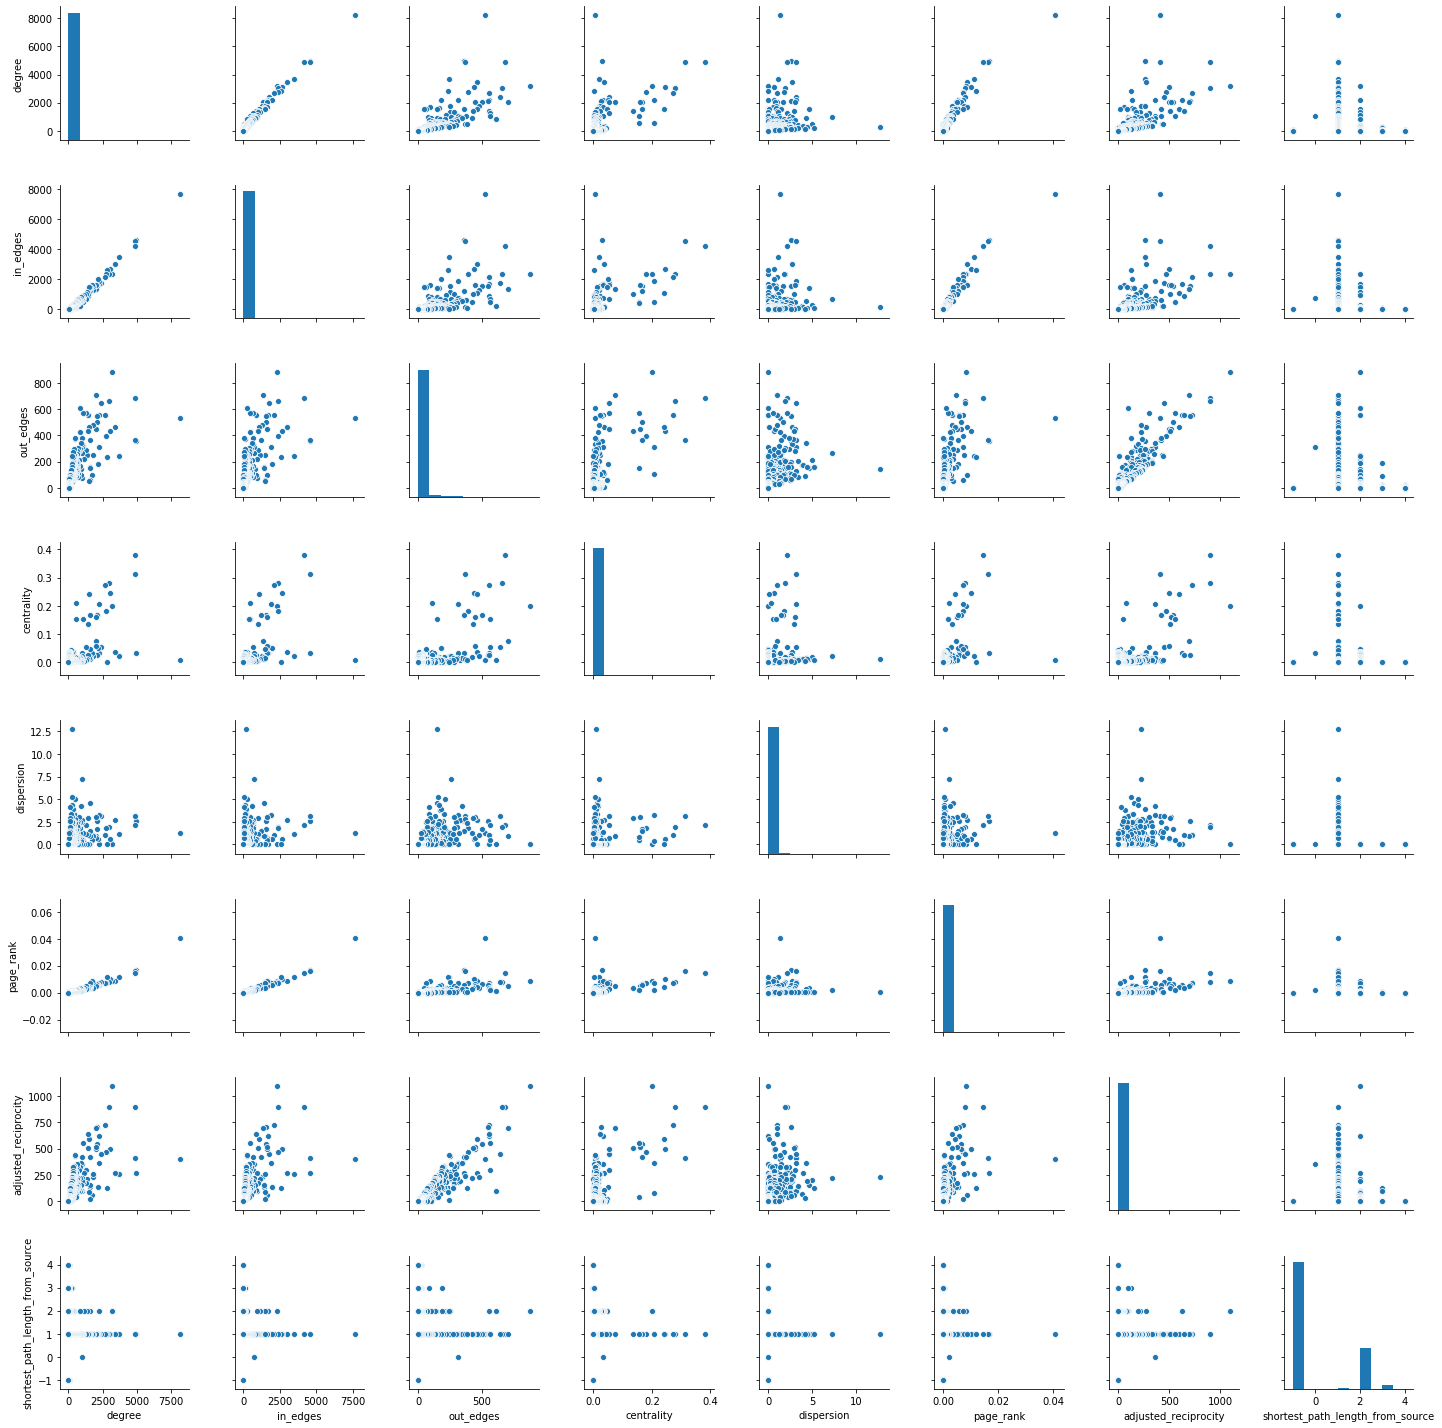

In [35]:
sns.pairplot(features_df)

In [ ]:
sns.heatmap(features_df.corr())

In [ ]:
features_df.info()

In [ ]:
len(gc.graph.nodes)

In [ ]:
gc.intro_nodes

In [ ]:
gc.get_dispersion(max_nodes=100)

In [ ]:
len(gc.graph.nodes)


In [ ]:
gc.get_degrees().head(25)

In [ ]:
gc.get_centrality().head(25)

In [ ]:
gc.get_shortes_path().head(25)

In [ ]:
gc.get_pageranks().head(25)

In [ ]:
gc.get_adjusted_reciprocity().head(25)

In [ ]:
gc.get_dominator_counts().head(25)

In [ ]:
ego = nx.ego_graph(gc.graph, "Regression analysis", undirected=True)
ego.name = "Regression analysis"
print(nx.info(ego))

In [ ]:
len(ego.nodes)

In [ ]:
nx.draw(ego)
plt.show()

In [ ]:
sorted([(key, value) for key, value in nx.eigenvector_centrality(ego).items()], key=lambda x: x[1], reverse=True)

In [ ]:
def sort_dict_values(dict, columns, sort_column, ascending=False):
    to_list = [(key, value) for key, value in dict.items()]
    return pd.DataFrame(to_list, columns=columns).sort_values(sort_column, ascending=ascending).reset_index().drop("index", axis=1)

In [ ]:
regression_ego = sort_dict_values(nx.betweenness_centrality(ego), ["node", "betweenness"], "betweenness")
regression_ego
# regression_ego[regression_ego.node == "Random forest"]